In [1]:
#Installing XGBoost
!pip install xgboost

  Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.26.5-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl (253.9 MB)
Using cached nvidia_nccl_cu12-2.26.5-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (318.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Importing all the needed libraries
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import time

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from openpyxl import load_workbook

In [3]:
#Reading the excel-document into a df
df = pd.read_excel('dataset_name.xlsx')

#dropping unwanted columns from the df
df2=df.drop(columns = ["Column 1", "Column 2"])

In [4]:
#Splitting df into two based on ID
df2["ID"] = df2["ID"].astype(str)  #Making sure its a string
df_train = df2[df2["ID"].isin(["ID 1", "ID 2", "ID 3"])]
df_unseen = df2[df2["ID"] == "ID 4"]

In [5]:
#defining which columns to keep av model input
X = df_train.drop(columns = ['Column 1', 'Column 2', 'Column 3'])

#defining which columns are the model outputs
y = df_train['Column 4']

#Setting up k-fold cross validation
k_fold = KFold(n_splits=10, random_state=66, shuffle=True)

10

In [6]:
#Initializing XGBoost classifier for multi-class classification
#"multi:softmax": outputs the class with the highest predicted probability
#"mlogloss": log loss metric for multi-class evaluation
XGB = xgb.XGBClassifier(objective="multi:softmax", eval_metric="mlogloss")

#Useing the first fold from K-Fold cross-validation
train_index, test_index = next(k_fold.split(X, y))
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#XGBoost requires class labels to be zero-indexed (starting from 0)
#Shifting all values to start from 0 by subtracting the minimum class value
y_train_fixed = y_train - y_train.min()
y_test_fixed = y_test - y_test.min()


In [7]:
#Initializing a StandardScaler to normalize feature values
scaler = StandardScaler()

#Fitting the scaler on the training data and transforming it
X_train_scaled = scaler.fit_transform(X_train)

#Transforming the test data using the same scaler
X_test_scaled = scaler.transform(X_test)


In [13]:
#Defining the hyperparameter grid for XGBoost classification
param_grid = {
    'n_estimators': [100, 200, 300],     # Number of boosting rounds (trees)
    'max_depth': [3, 6, 9, 12],          # Maximum depth of each tree (controls model complexity)
    'learning_rate': [0.04, 0.05, 0.06], # Step size shrinkage (lower = more robust, slower learning)
    'subsample': [0.6, 0.7, 0.8],        # Fraction of training samples to use per boosting round (controls overfitting)
    'colsample_bytree': [0.5,0.6,0.7],   # Fraction of features used per tree (helps generalization)
    'reg_alpha': [0.1, 1],               # L1 regularization term (sparse weights)
    'reg_lambda': [1, 10],               # L2 regularization term (shrinks weights)
}

#Setting up GridSearchCV to tune hyperparameters
CV_XGB = GridSearchCV(
    XGB,                             
    param_grid,                       
    cv=5,                             
    scoring='f1_weighted',           
    n_jobs=-1,                        
    verbose=1                        
)

#Fitting GridSearchCV using the scaled training data and zero-based target labels
CV_XGB.fit(X_train_scaled, y_train_fixed)

#Printing the best combination of hyperparameters found
print('Best Parameters: ', CV_XGB.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters:  {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.7}


In [14]:
#Getting the best XGBoost model from GridSearchCV
XGB_best = CV_XGB.best_estimator_

#Storing the best hyperparameters
best_params = CV_XGB.best_params_

#Making predictions on the training set using the best model
pred_train = XGB_best.predict(X_train_scaled)

#Making predictions on the test set using the same model
pred_test = XGB_best.predict(X_test_scaled)


Train Accuracy: 0.9931
Train Precision: 0.9932
Train Recall: 0.9931
Train F1 Score: 0.9931


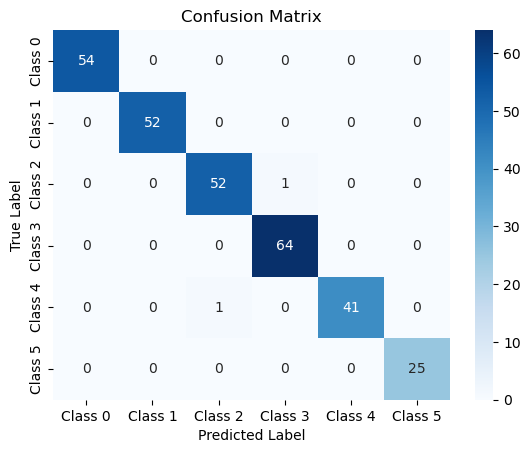

In [15]:
#Evaluating model performance on the training data
acc_train = accuracy_score(y_train_fixed, pred_train)
precision_train = precision_score(y_train_fixed, pred_train, average='weighted')
recall_train = recall_score(y_train_fixed, pred_train, average='weighted')
f1_train = f1_score(y_train_fixed, pred_train, average='weighted')

#Printing training performance metrics
print(f'Train Accuracy: {acc_train:.4f}')
print(f'Train Precision: {precision_train:.4f}')
print(f'Train Recall: {recall_train:.4f}')
print(f'Train F1 Score: {f1_train:.4f}')

#Generating confusion matrix to visualize prediction errors and correct classifications
cm = confusion_matrix(y_train_fixed, pred_train)

#Creating class labels for the heatmap
class_labels = [f"Class {i}" for i in np.unique(y_train_fixed)]

#Plotting the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Test Accuracy: 0.8485
Test Precision: 0.8654
Test Recall: 0.8485
Test F1 Score: 0.8487


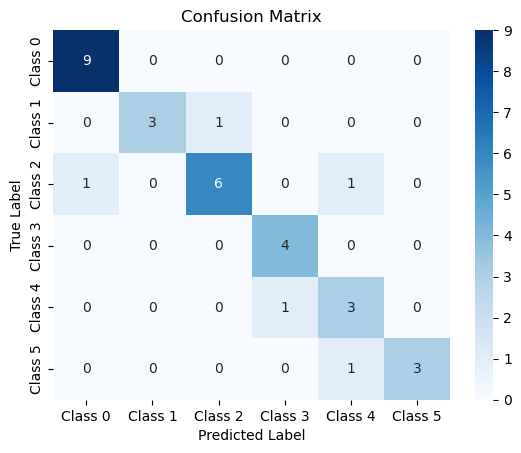

In [16]:
#Evaluating model performance on the test data
acc_test = accuracy_score(y_test_fixed, pred_test)
precision_test = precision_score(y_test_fixed, pred_test, average='weighted')
recall_test = recall_score(y_test_fixed, pred_test, average='weighted')
f1_test = f1_score(y_test_fixed, pred_test, average='weighted')

#Printing test performance metrics
print(f'Test Accuracy: {acc_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')

#Generating confusion matrix for the test set
cm = confusion_matrix(y_test_fixed, pred_test)

#Defining class labels for the confusion matrix
class_labels = [f"Class {i}" for i in np.unique(y_test_fixed)]

#Plotting the confusion matrix as a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Unseen Accuracy: 0.1102
Unseen Precision: 0.0979
Unseen Recall: 0.1102
Unseen F1 Score: 0.1037


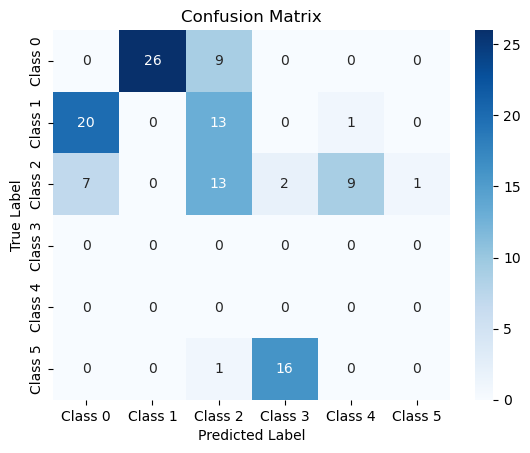

Confusion Matrix:
 [[ 0 26  9  0  0  0]
 [20  0 13  0  1  0]
 [ 7  0 13  2  9  1]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  1 16  0  0]]


In [17]:
#Defining inputs and outputs for unseen dataset
X_unseen = df_unseen.drop(columns = ['Column 1', 'Column 2', 'Column 3')
y_unseen = df_unseen['Column 4']

#Changing unseen labels to start from 0, like the training labels used in XGBoost
y_unseen_fixed = y_unseen - y_train.min()

#Scaling unseen features using the same scaler fitted on training data
X_unseen_scaled = scaler.transform(X_unseen)

#Making predictions on the unseen data using the tuned XGBoost model
y_pred_unseen = XGB_best.predict(X_unseen_scaled)

#Computing evaluation metrics for the unseen set
acc_unseen = accuracy_score(y_unseen_fixed, y_pred_unseen)                       
precision_unseen = precision_score(y_unseen_fixed, y_pred_unseen, average='weighted', zero_division=0)
recall_unseen = recall_score(y_unseen_fixed, y_pred_unseen, average='weighted', zero_division=0)
f1_unseen = f1_score(y_unseen_fixed, y_pred_unseen, average='weighted', zero_division=0)

#Printing unseen performance metrics
print(f'Unseen Accuracy: {acc_unseen:.4f}')
print(f'Unseen Precision: {precision_unseen:.4f}')
print(f'Unseen Recall: {recall_unseen:.4f}')
print(f'Unseen F1 Score: {f1_unseen:.4f}')

#Generating and visualizing confusion matrix
cm_unseen = confusion_matrix(y_unseen_fixed, y_pred_unseen)

#making sure class labels in the heatmap match both predicted and actual labels
all_labels = np.unique(np.concatenate((y_unseen_fixed, y_pred_unseen)))
class_labels = [f"Class {i}" for i in all_labels]

#Plotting confusion matrix
sns.heatmap(cm_unseen, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [16]:
#Defining a function to log model evaluation metrics and hyperparameters to an Excel-file of chosen name
def log_results(model_name, params, accuracy_train, precision_train, recall_train, f1_train,
                accuracy_test, precision_test, recall_test, f1_test,
                accuracy_unseen, precision_unseen, recall_unseen, f1_unseen,
                filename="Results.xlsx"):
    """ Logs classification model results in separate sheets within the same Excel file, ensuring appending works correctly. """

    #Creating DataFrame for this model run
    result = pd.DataFrame([{
        **params,
        "Accuracy_Train": accuracy_train,
        "Precision_Train": precision_train,
        "Recall_Train": recall_train,
        "F1_Train": f1_train,
        "Accuracy_Test": accuracy_test,
        "Precision_Test": precision_test,
        "Recall_Test": recall_test,
        "F1_Test": f1_test,
        "Accuracy_Unseen": accuracy_unseen,
        "Precision_Unseen": precision_unseen,
        "Recall_Unseen": recall_unseen,
        "F1_Unseen": f1_unseen
    }])

    # Introducing a short delay to avoid file conflicts if running in multiple notebooks
    time.sleep(1)

    #Checking if the file exists
    file_exists = os.path.exists(filename)

    if not file_exists:
        #If file doesn't exist, creating a new one
        with pd.ExcelWriter(filename, engine="openpyxl", mode="w") as writer:
            result.to_excel(writer, sheet_name=model_name, index=False)
    else:
        #If file exists, loading it properly before appending
        try:
            with pd.ExcelWriter(filename, engine="openpyxl", mode="a", if_sheet_exists="overlay") as writer:
                #Read existing sheet
                try:
                    existing_df = pd.read_excel(filename, sheet_name=model_name, engine="openpyxl")
                    df_combined = pd.concat([existing_df, result], ignore_index=True)
                except (FileNotFoundError, ValueError):
                    df_combined = result  #If sheet does not exist, creating it

                #Saving results
                df_combined.to_excel(writer, sheet_name=model_name, index=False)

        except PermissionError:
            #Printing error to warn user
            print(f"Error: Close the Excel file ({filename}) before running the script again.")
            
    #Printing a confirmation to ensure user results are logged
    print(f"✅ Logged results for {model_name}: Train Accuracy={accuracy_train:.4f}, Test Accuracy={accuracy_test:.4f}, Unseen Accuracy={accuracy_unseen:.4f}")



In [17]:
log_results(
    model_name="XGB-Kfold",
    params=best_params,

    accuracy_train=acc_train,
    precision_train=precision_train,
    recall_train=recall_train,
    f1_train=f1_train,

    accuracy_test=acc_test,
    precision_test=precision_test,
    recall_test=recall_test,
    f1_test=f1_test,

    accuracy_unseen=acc_unseen,
    precision_unseen=precision_unseen,
    recall_unseen=recall_unseen,
    f1_unseen=f1_unseen
)


✅ Logged results for XGB-Kfold: Train Accuracy=0.9966, Test Accuracy=0.8788, Unseen Accuracy=0.1186
